In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

# Load the dataset
df = pd.read_csv('goals_predict.csv')

# One-hot encode 'position' and 'foot'
df_processed = pd.get_dummies(df, columns=['position', 'foot'], dtype=int)

# Convert 'age_at_season_start' to integer
df_processed['age_at_season_start'] = df_processed['age_at_season_start'].astype(int)

# Define features (X) and targets (y)
# Drop columns not needed for training, including the original target columns for X
X = df_processed.drop([
    'player_id', 'name', 'avg_market_value_season',
    'foot_both', 'position_Missing', # 'foot_both' and 'position_Missing' are often dropped after one-hot encoding to avoid multicollinearity
    'total_goals_season', 'total_assists_season'
], axis=1)
y = df_processed[['total_goals_season', 'total_assists_season']]

print("Data loading and initial preprocessing complete using Pandas.")
print("X head:")
print(X.head())
print("\nY head:")
print(y.head())


2025-08-06 08:35:12.953994: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data loading and initial preprocessing complete using Pandas.
X head:
   season  age_at_season_start  height_in_cm  appearances_season  \
0    2012                   34         184.0                  36   
1    2013                   35         184.0                  29   
2    2014                   36         184.0                  40   
3    2015                   37         184.0                  31   
4    2012                   31         179.0                  15   

   total_minutes_played_season  position_Attack  position_Defender  \
0                         2585                1                  0   
1                         2220                1                  0   
2                         2289                1                  0   
3                         1714                1                  0   
4                          904                0                  0   

   position_Midfield  foot_left  foot_right  
0                  0          0           1  
1       

In [2]:
# --- 2. Train-Test Split ---
# Using sklearn's train_test_split for convenience and best practices
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTrain-test split complete using Scikit-learn.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")



Train-test split complete using Scikit-learn.
X_train shape: (61832, 10)
X_test shape: (15459, 10)
y_train shape: (61832, 2)
y_test shape: (15459, 2)


In [3]:
# --- 3. Scaling (Standardization) and Log Transformation for Targets ---
# Identify numerical columns in X for standardization
# Exclude one-hot encoded columns as they are already binary
numerical_cols_X = [col for col in X_train.columns if not (col.startswith('position_') or col.startswith('foot_'))]
# Ensure 'player_id', 'name', 'avg_market_value_season' are not in X_train if they were not dropped earlier
# (They were dropped in Step 1, so this list should be accurate for remaining numericals)
# Initialize and fit StandardScaler for X on training data
scaler_X = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_cols_X] = scaler_X.fit_transform(X_train[numerical_cols_X])
X_test_scaled[numerical_cols_X] = scaler_X.transform(X_test[numerical_cols_X]) # Use transform, not fit_transform for test set
# Log transform y (goals and assists)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
# Initialize and fit StandardScaler for y on log-transformed training data
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_log)
y_test_scaled = scaler_y.transform(y_test_log) # Use transform for test set
# Convert scaled y back to DataFrame for consistency if needed later, or keep as numpy array
y_train_scaled_df = pd.DataFrame(y_train_scaled, columns=y_train.columns, index=y_train.index)
y_test_scaled_df = pd.DataFrame(y_test_scaled, columns=y_test.columns, index=y_test.index)
print("\nScaling and log transformation complete.")
print("X_train_scaled head:")
print(X_train_scaled.head())
print("\ny_train_scaled (first 5 rows, as numpy array):")
print(y_train_scaled[:5])


Scaling and log transformation complete.
X_train_scaled head:
         season  age_at_season_start  height_in_cm  appearances_season  \
46242 -0.539415            -0.619991      1.002419           -0.586670   
9900   0.811109             2.100753      0.072100           -0.667766   
40754  1.081214             1.193838      0.692312            0.224290   
73885  1.351319            -0.393262      1.157472           -0.748862   
33561  1.081214             1.420567      0.847365            0.467578   

       total_minutes_played_season  position_Attack  position_Defender  \
46242                    -0.778667                1                  0   
9900                     -0.877804                0                  0   
40754                     0.556768                0                  1   
73885                    -1.008043                0                  0   
33561                     0.578150                0                  1   

       position_Midfield  foot_left  foot_right

In [4]:
# --- 4. Define the MLP Model Architecture using Keras ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Determine the input shape (number of features)
input_shape = X_train_scaled.shape[1]
output_shape = y_train_scaled.shape[1] # Should be 2 for goals and assists
 # Define the model
model = Sequential([
    # Input Layer + First Hidden Layer
    # We'll start with 64 neurons, using ReLU activation.
    # input_shape specifies the number of features in our input data.
    Dense(64, activation='relu', input_shape=(input_shape,)),
    # Second Hidden Layer (optional, but often improves performance)
    Dense(32, activation='relu'),
    # Output Layer
    # 2 neurons for the two target variables (goals, assists).
    # 'linear' activation is standard for regression tasks.
    # If you want to strictly enforce non-negative predictions, 'relu' could be used here,
    # but it might clip valid small positive values. The log transform and inverse transform
    # combined with linear output often work well.
    Dense(output_shape, activation='linear')
])

 # Display the model summary to see the layers and parameter counts
model.summary()

print("\nMLP model architecture defined using Keras.")


/home/areeb/football/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,850 (11.13 KB)

 Trainable params: 2,850 (11.13 KB)

 Non-trainable params: 0 (0.00 B)


MLP model architecture defined using Keras.


In [5]:
# --- 5. Compile the Model and Choose Loss Function/Optimizer ---
# Compile the model
# Optimizer: 'adam' is a good general-purpose optimizer.
# Loss: 'mse' (Mean Squared Error) is standard for regression.
# Metrics: 'mae' (Mean Absolute Error) is also useful to monitor.
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print("\nMLP model compiled.")
print("Optimizer: Adam")
print("Loss Function: Mean Squared Error (MSE)")
print("Metrics: Mean Absolute Error (MAE)")



MLP model compiled.
Optimizer: Adam
Loss Function: Mean Squared Error (MSE)
Metrics: Mean Absolute Error (MAE)


In [6]:
# --- 6. Train the MLP Model ---
print("\nStarting MLP model training...")
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=10,          # Number of times to iterate over the entire dataset
    batch_size=128,       # Number of samples per gradient update
    validation_split=0.1, # Use 10% of the training data for validation
    verbose=1            # Show progress bar during training
)
print("\nMLP model training complete.")
print("Training history (loss and metrics per epoch) is stored in the 'history' object.")



Starting MLP model training...
Epoch 1/10


435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4793 - mae: 0.5361 - val_loss: 0.4297 - val_mae: 0.5107
Epoch 2/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4249 - mae: 0.5034 - val_loss: 0.4271 - val_mae: 0.5020
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4221 - mae: 0.5006 - val_loss: 0.4257 - val_mae: 0.5032
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4205 - mae: 0.4993 - val_loss: 0.4235 - val_mae: 0.5032
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4191 - mae: 0.4983 - val_loss: 0.4226 - val_mae: 0.4961
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4180 - mae: 0.4976 - val_loss: 0.4206 - val_mae: 0.4982
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4177 - mae: 0.4971 - val_loss: 0.4232 - val_mae: 0.4950
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4172 - mae: 0.4964 - val_loss: 0.4221 - val_mae: 0.4977
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4168 

In [7]:
# # --- 6. Train the MLP Model (with Early Stopping) ---
# from tensorflow.keras.callbacks import EarlyStopping
# print("\nStarting MLP model training with Early Stopping...")
# # Define the EarlyStopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss',      # Metric to monitor (validation loss)
#      patience=10,             # Number of epochs with no improvement after which training will be stopped
#      restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric
# )
# history = model.fit(
#     X_train_scaled,
#     y_train_scaled,
#     epochs=200,          # Set a higher number of epochs, as Early Stopping will stop it when needed
#     batch_size=32,
#     validation_split=0.1,
#     callbacks=[early_stopping], # Pass the early stopping callback here
#     verbose=1
# )
# print("\nMLP model training complete (Early Stopping applied).")
# print("Training history (loss and metrics per epoch) is stored in the 'history' object.")


In [8]:
# --- 7. Evaluate the Model on Test Data and Inverse Transform Predictions ---
print("\nEvaluating model on test data and inverse transforming predictions...")
# Make predictions on the scaled test data
y_test_pred_scaled = model.predict(X_test_scaled)
# Inverse transform the predictions to the original scale
# First, inverse standardize
y_test_pred_log = scaler_y.inverse_transform(y_test_pred_scaled)
# Then, inverse log transform (np.expm1 is the inverse of np.log1p)
y_test_pred_final = np.expm1(y_test_pred_log)
# Ensure predictions are non-negative (goals/assists cannot be negative)
y_test_pred_final[y_test_pred_final < 0] = 0
# Convert actual y_test to a NumPy array for direct comparison
y_actual = y_test.values
# Calculate evaluation metrics on the original scale
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_actual, y_test_pred_final)
mae = mean_absolute_error(y_actual, y_test_pred_final)
print(f"\nEvaluation on Test Data (Original Scale):")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
# Display a comparison of actual vs. predicted for a few samples
df_compare = pd.DataFrame({
    'Actual_goals': y_actual[:10, 0],
    'Predicted_goals': y_test_pred_final[:10, 0],
    'Actual_assists': y_actual[:10, 1],
    'Predicted_assists': y_test_pred_final[:10, 1]
})
print("\nSample Predictions vs Actuals (first 10 test samples):")
print(df_compare)


Evaluating model on test data and inverse transforming predictions...
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Evaluation on Test Data (Original Scale):
Mean Squared Error (MSE): 3.96
Mean Absolute Error (MAE): 1.13

Sample Predictions vs Actuals (first 10 test samples):
   Actual_goals  Predicted_goals  Actual_assists  Predicted_assists
0             0         0.005402               0           0.046251
1             1         1.079859               3           4.198160
2             1         1.301984               3           0.757616
3             0         0.056955               0           0.073980
4             1         0.657515               0           0.301162
5             0         0.199304               2           0.205272
6             0         1.197721               0           1.472317
7             0         1.279922               2           1.537890
8             0         0.490559               1           0.672259
9             3         0.423478              


Plotting learning curves...


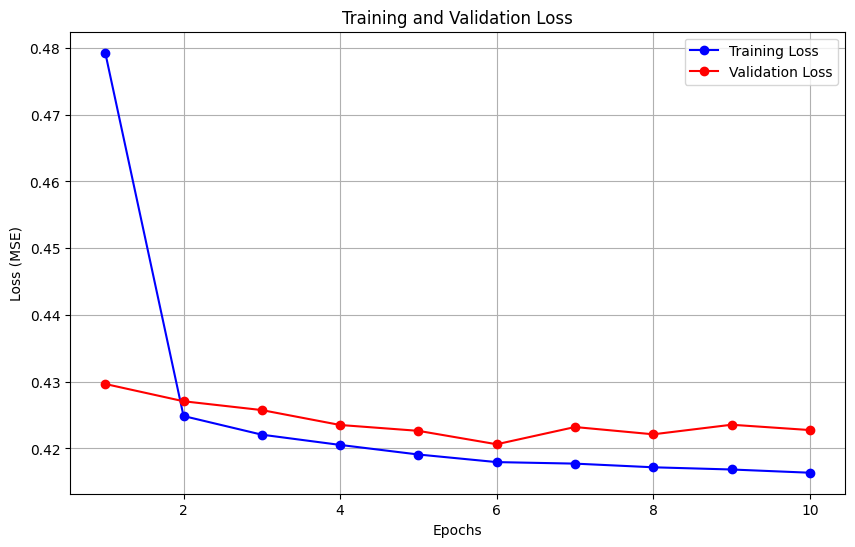

Learning curves plotted. Analyze the plot to determine model fit.


In [9]:
# --- 8. Plot Learning Curves ---
import matplotlib.pyplot as plt
print("\nPlotting learning curves...")
# Get the loss and validation loss from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()
print("Learning curves plotted. Analyze the plot to determine model fit.")


In [10]:
# --- 9. Output Training and Validation Loss at Start and End ---
print("\n--- Training and Validation Loss Summary ---")
# Loss at the start of training (first epoch)
initial_train_loss = history.history['loss'][0]
initial_val_loss = history.history['val_loss'][0]
print(f"Initial Training Loss (Epoch 1): {initial_train_loss:.4f}")
print(f"Initial Validation Loss (Epoch 1): {initial_val_loss:.4f}")
# Loss at the end of training (last epoch)
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"Final Training Loss (Epoch {len(history.history['loss'])}): {final_train_loss:.4f}")
print(f"Final Validation Loss (Epoch {len(history.history['loss'])}): {final_val_loss:.4f}")
print("------------------------------------------")



--- Training and Validation Loss Summary ---
Initial Training Loss (Epoch 1): 0.4793
Initial Validation Loss (Epoch 1): 0.4297
Final Training Loss (Epoch 10): 0.4164
Final Validation Loss (Epoch 10): 0.4228
------------------------------------------


/tmp/ipykernel_1309/640721829.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_goals = df_results.groupby('goal_bins')['residual_goals'].mean()
/tmp/ipykernel_1309/640721829.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_assists = df_results.groupby('assist_bins')['residual_assists'].mean()
/tmp/ipykernel_1309/640721829.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_bin_centers = df_res

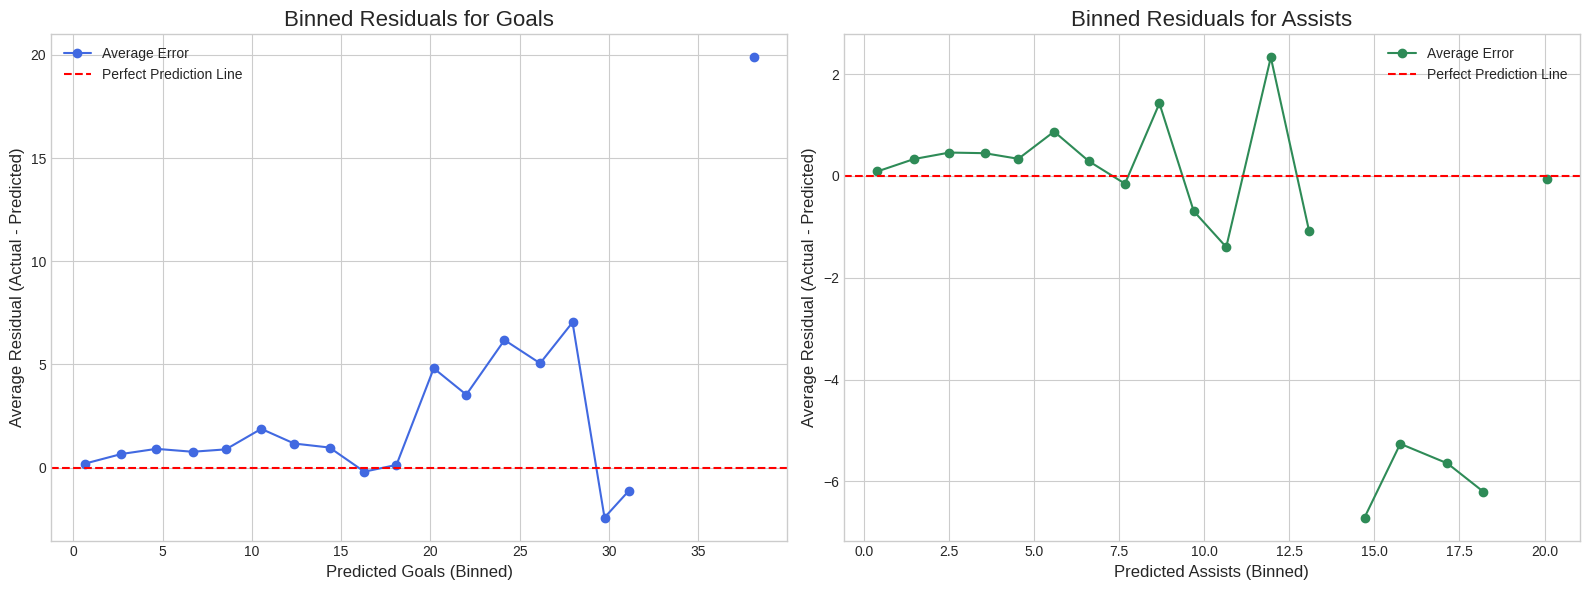

In [11]:
# --- Binned Residual Plots ---
# This is a much clearer way to see systematic bias than a raw scatter or hexbin plot.
# First, create a DataFrame to hold our predictions and residuals
df_results = pd.DataFrame({
    'predicted_goals': y_test_pred_final[:, 0],
    'residual_goals': y_actual[:, 0] - y_test_pred_final[:, 0],
    'predicted_assists': y_test_pred_final[:, 1],
    'residual_assists': y_actual[:, 1] - y_test_pred_final[:, 1]
})
# --- Binning for Goals ---
# Create bins based on the predicted goal values. We use pd.cut to do this automatically.
# We'll create 20 bins.
df_results['goal_bins'] = pd.cut(df_results['predicted_goals'], bins=20)
# Group by the bins and calculate the mean residual for each bin
binned_goals = df_results.groupby('goal_bins')['residual_goals'].mean()
# --- Binning for Assists ---
df_results['assist_bins'] = pd.cut(df_results['predicted_assists'], bins=20)
binned_assists = df_results.groupby('assist_bins')['residual_assists'].mean()
# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# Plot for Goals
# We plot the mean of each bin's predicted value on the x-axis
goal_bin_centers = df_results.groupby('goal_bins')['predicted_goals'].mean()
ax1.plot(goal_bin_centers, binned_goals, 'o-', color='royalblue', label='Average Error')
ax1.axhline(y=0, color='r', linestyle='--', label='Perfect Prediction Line')
ax1.set_title('Binned Residuals for Goals', fontsize=16)
ax1.set_xlabel('Predicted Goals (Binned)', fontsize=12)
ax1.set_ylabel('Average Residual (Actual - Predicted)', fontsize=12)
ax1.legend()
ax1.grid(True)
# Plot for Assists
assist_bin_centers = df_results.groupby('assist_bins')['predicted_assists'].mean()
ax2.plot(assist_bin_centers, binned_assists, 'o-', color='seagreen', label='Average Error')
ax2.axhline(y=0, color='r', linestyle='--', label='Perfect Prediction Line')
ax2.set_title('Binned Residuals for Assists', fontsize=16)
ax2.set_xlabel('Predicted Assists (Binned)', fontsize=12)
ax2.set_ylabel('Average Residual (Actual - Predicted)', fontsize=12)
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

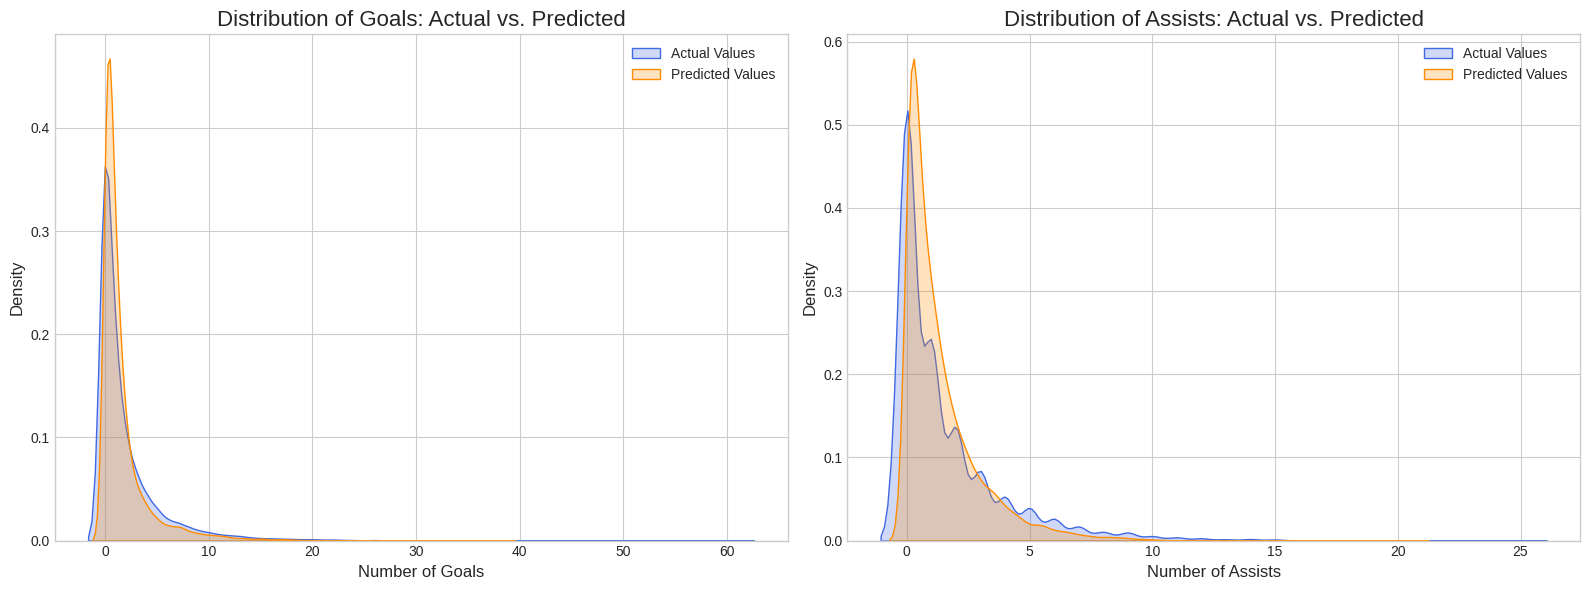

In [13]:
import seaborn as sns

# --- Plotting the Distribution of Predictions vs. Actuals ---
# This provides a clear, high-level view of model performance.
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# --- Plot for Goals ---
sns.kdeplot(y_actual[:, 0], color='royalblue', label='Actual Values', ax=ax1, fill=True)
sns.kdeplot(y_test_pred_final[:, 0], color='darkorange', label='Predicted Values', ax=ax1, fill=True)
ax1.set_title('Distribution of Goals: Actual vs. Predicted', fontsize=16)
ax1.set_xlabel('Number of Goals', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.legend()
# --- Plot for Assists ---
sns.kdeplot(y_actual[:, 1], color='royalblue', label='Actual Values', ax=ax2, fill=True)
sns.kdeplot(y_test_pred_final[:, 1], color='darkorange', label='Predicted Values', ax=ax2, fill=True)
ax2.set_title('Distribution of Assists: Actual vs. Predicted', fontsize=16)
ax2.set_xlabel('Number of Assists', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.legend()
plt.tight_layout()
plt.show()


In [16]:
# --- Save the Model and Scalers ---
import os
import pickle

# Define save directory
save_dir = '../saved_model'
os.makedirs(save_dir, exist_ok=True)

# Save the trained model in the recommended Keras format
model_path = os.path.join(save_dir, 'fnn_model.keras')
model.save(model_path)
print(f"Model saved to {model_path}")

# Save the scalers in the same folder
scaler_X_path = os.path.join(save_dir, 'scaler_X.pkl')
with open(scaler_X_path, 'wb') as f:
    pickle.dump(scaler_X, f)
print(f"scaler_X saved to {scaler_X_path}")

scaler_y_path = os.path.join(save_dir, 'scaler_y.pkl')
with open(scaler_y_path, 'wb') as f:
    pickle.dump(scaler_y, f)
print(f"scaler_y saved to {scaler_y_path}")


Model saved to ../saved_model/fnn_model.keras
scaler_X saved to ../saved_model/scaler_X.pkl
scaler_y saved to ../saved_model/scaler_y.pkl


In [ ]:
# --- 11. Save the Basic FNN Model and Scalers ---
import os
import pickle
from tensorflow.keras.models import load_model
# Define the directory to save the assets
save_dir = 'saved_model/fnn'
os.makedirs(save_dir, exist_ok=True)
# --- Save the Trained Model ---
# This is the 'model' variable from this notebook
model_path = os.path.join(save_dir, 'fnn_model_basic.keras')
model.save(model_path)
print(f"✅ Basic FNN model saved to:  {model_path}")
# --- Save the Feature Scaler (scaler_X) ---
scaler_X_path = os.path.join(save_dir, 'scaler_X_basic.pkl')
with open(scaler_X_path, 'wb') as f:
    pickle.dump(scaler_X, f)
print(f"✅ Basic feature scaler (scaler_X_basic) saved to:  {scaler_X_path}")
# --- Save the Target Scaler (scaler_y) ---
# This scaler handles both the log-transformation and standardization of the targets.
scaler_y_path = os.path.join(save_dir, 'scaler_y_basic.pkl')
with open(scaler_y_path, 'wb') as f:
    pickle.dump(scaler_y, f)
print(f"✅ Basic target scaler (scaler_y_basic) saved to:  {scaler_y_path}")
print("\nAll necessary assets for the basic FNN model have been saved.")


In [ ]:
# --- Save the Basic FNN Model and Scalers ---
import os
import pickle
# Define the directory to save the assets
save_dir = 'saved_model/fnn_basic'
os.makedirs(save_dir, exist_ok=True)
# --- Save the Trained Model ---
model_path = os.path.join(save_dir, 'fnn_model.keras')
model.save(model_path)
print(f"✅ Basic FNN model saved to:  {model_path}")
# --- Save the Feature Scaler (scaler_X) ---
scaler_X_path = os.path.join(save_dir, 'scaler_X.pkl')
with open(scaler_X_path, 'wb') as f:
    pickle.dump(scaler_X, f)
print(f"✅ Basic feature scaler (scaler_X) saved to:  {scaler_X_path}")
# --- Save the Target Scaler (scaler_y) ---
scaler_y_path = os.path.join(save_dir, 'scaler_y.pkl')
with open(scaler_y_path, 'wb') as f:
    pickle.dump(scaler_y, f)
print(f"✅ Basic target scaler (scaler_y) saved to:  {scaler_y_path}")
# --- Save the Column Order ---
col_order = X_train.columns.tolist()
col_order_path = os.path.join(save_dir, 'col_order.pkl')
with open(col_order_path, 'wb') as f:
    pickle.dump(col_order, f)
print(f"✅ Column order saved to:  {col_order_path}")
print("\nAll necessary assets for the basic FNN model have been saved.")
